### Definición de funciones y carga de datos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import mahalanobis

#Fijar la semilla aleatoria
np.random.seed(42)

def kmeans_mahalanobis(X, k, max_iters=100):    
    # Inicializar centroides aleatoriamente
    np.random.seed(42)  # Fijar la semilla aquí también
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]
    # Calcular la matriz de covarianza inversa
    VI = np.linalg.inv(np.cov(X.T))
    
    for _ in range(max_iters):
        # Calcular distancias de Mahalanobis
        distances = np.array([[mahalanobis(x, c, VI) for c in centroids] for x in X])
        # Asignar etiquetas basadas en la distancia mínima
        labels = np.argmin(distances, axis=1)
        # Calcular nuevos centroides
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
        
        # Verificar convergencia
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    
    # Calcular las distancias de cada punto al centroide correspondiente
    min_distances = distances[np.arange(len(X)), labels]
    return centroids, labels, min_distances

def metodo_del_codo(X, max_k=10):
    wcss = []
    for k in range(1, max_k + 1):
        centroids, labels, min_distances = kmeans_mahalanobis(X, k)
        wcss.append(np.sum(min_distances ** 2))
    
    plt.plot(range(1, max_k + 1), wcss, marker='o', linestyle='-')
    plt.xlabel('Número de clústeres')
    plt.ylabel('WCSS')
    plt.title('Método del codo para encontrar el k óptimo')
    plt.show()

data_train=pd.read_excel('Datos_train.xlsx',index_col=0)
data_test = pd.read_excel('Datos_test.xlsx',index_col=0)  
etiq_verd_train=data_train[['Etiq']]
etiq_verd_test=data_test[['Etiq']]
data_train = data_train[['Temperatura','Consumo_Lavanderia', 'Consumo_Cocina', 
                         'Resto_Consumo', 'Habitantes']]
data_test = data_test[['Temperatura','Consumo_Lavanderia', 'Consumo_Cocina', 
                         'Resto_Consumo', 'Habitantes']]

print(data_train.head())
print(data_test.head())

data_train=np.array(data_train)
data_test=np.array(data_test)

     Temperatura  Consumo_Lavanderia  Consumo_Cocina  Resto_Consumo  \
518     0.395349            0.246374        0.331337       0.111447   
601     0.395349            0.198473        0.273396       0.490744   
602     0.139535            0.167176        0.252471       0.490744   
968     0.418605            0.317557        0.151627       0.576502   
325     0.651163            0.231298        0.182481       0.492255   

     Habitantes  
518      0.5625  
601      0.2500  
602      0.2500  
968      0.5625  
325      0.3750  
      Temperatura  Consumo_Lavanderia  Consumo_Cocina  Resto_Consumo  \
847      0.604651            0.203817        0.187748       0.219500   
298      0.232558            0.360687        0.181398       0.105780   
197      0.418605            0.243321        0.338336       0.170759   
1065     0.441860            0.244656        0.129014       0.223649   
881      0.697674            0.298664        0.159391       0.408765   

      Habitantes  
847       0.4

### Método del codo

<IPython.core.display.Javascript object>


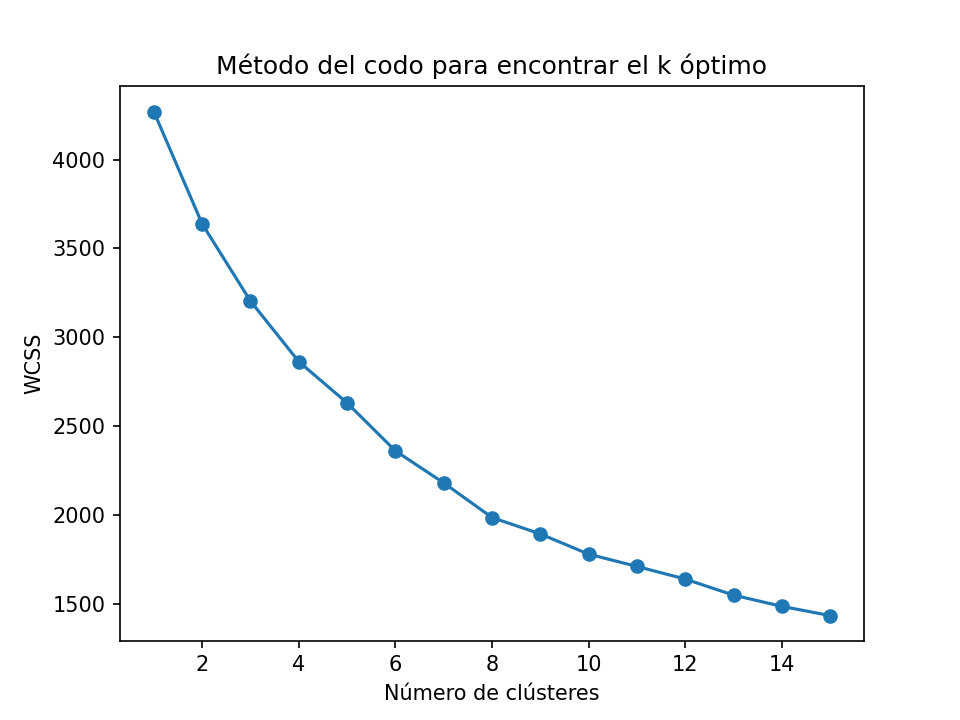

In [40]:
metodo_del_codo(data_train,15)

### Entrenamiento del modelo

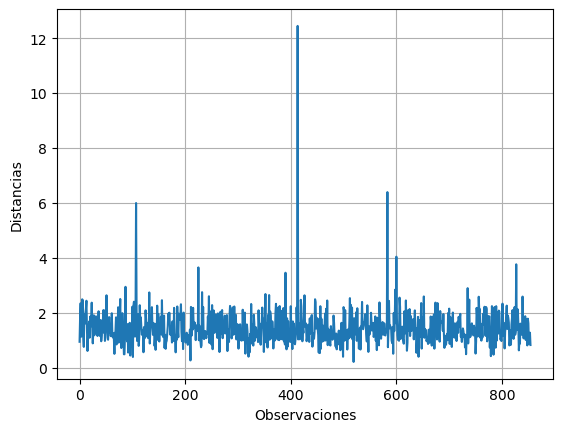

7
[[0.46495017 0.30779621 0.17548267 0.19970334 0.39017857]
 [0.36916729 0.21969712 0.32651148 0.29364737 0.56330645]
 [0.48475801 0.15298638 0.29673322 0.59490346 0.55827703]
 [0.54302326 0.25006489 0.16067537 0.46119003 0.79125   ]
 [0.67334937 0.37301856 0.21890982 0.62739521 0.44468391]
 [0.77494374 0.19114771 0.20925667 0.33263522 0.32459677]
 [0.34011628 0.28969321 0.20759128 0.59914025 0.44318182]]


In [2]:
centroids, labels, distances=kmeans_mahalanobis(data_train, 7, max_iters=100)

plt.grid(True)
plt.plot(distances)
plt.xlabel('Observaciones')
plt.ylabel('Distancias')
plt.show()

print(len(centroids))
print(centroids)

### Análisis de TDA, TFA, Precisión y Umbral

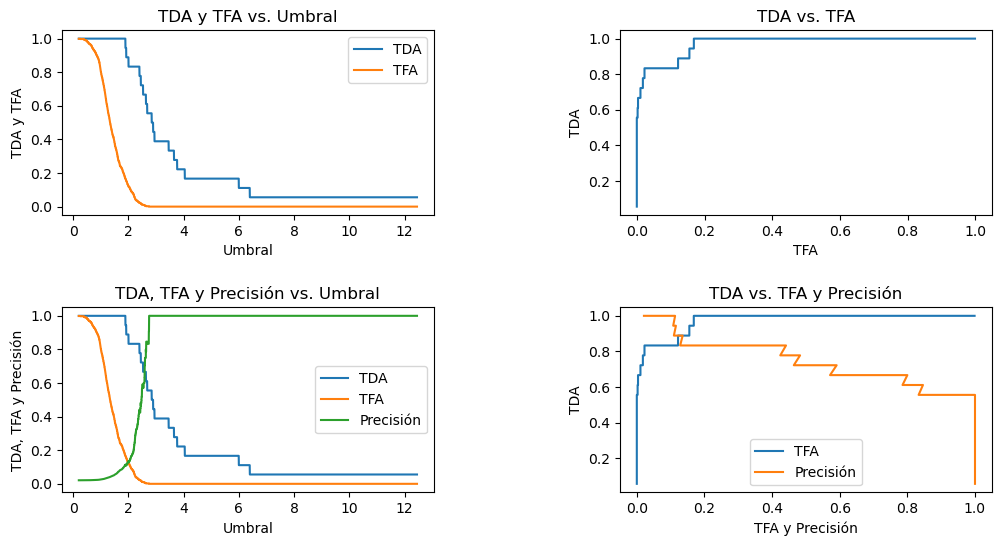

In [3]:
from sklearn.metrics import confusion_matrix

umbral = np.arange(np.min(distances), np.max(distances), 0.001)

tda=[]
tfa=[]
precis=[]

for i in range(len(umbral)):
    predicciones = np.where(distances > umbral[i], 1, 0)
    cm = confusion_matrix(etiq_verd_train, predicciones) 
    VP = cm[1, 1]
    FP = cm[0, 1]
    VN = cm[0, 0]
    FN = cm[1, 0]
    TDA= VP/(VP+FN) # Describe a la clase positiva (Clase Pos=VP+FN;Clase Neg=VN+FP)
    TFA=FP/(VN+FP)
    PREC=VP/(VP+FP) # Describe a las predicciones positivas correctas (PrediccPosit=VP+FP)
    tda.append(TDA)
    tfa.append(TFA)
    precis.append(PREC)
    
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
ax1, ax2, ax3, ax4 = axes.flatten()

ax1.plot(umbral, tda, label='TDA')
ax1.plot(umbral, tfa, label='TFA')
ax1.set_xlabel('Umbral')  
ax1.set_ylabel('TDA y TFA') 
ax1.set_title('TDA y TFA vs. Umbral')
ax1.legend()

ax2.plot(tfa, tda)
ax2.set_xlabel('TFA')  
ax2.set_ylabel('TDA')  
ax2.set_title('TDA vs. TFA')

ax3.plot(umbral, tda, label='TDA')
ax3.plot(umbral, tfa, label='TFA')
ax3.plot(umbral,precis,label='Precisión')
ax3.set_xlabel('Umbral')  
ax3.set_ylabel('TDA, TFA y Precisión') 
ax3.set_title('TDA, TFA y Precisión vs. Umbral')
ax3.legend()

ax4.plot(tfa,tda,label='TFA')
ax4.plot(precis, tda, label='Precisión')
ax4.set_xlabel('TFA y Precisión') 
ax4.set_ylabel('TDA') 
ax4.set_title('TDA vs. TFA y Precisión')
ax4.legend()

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

### Selección manual de valores de TDA y TFA

<IPython.core.display.Javascript object>


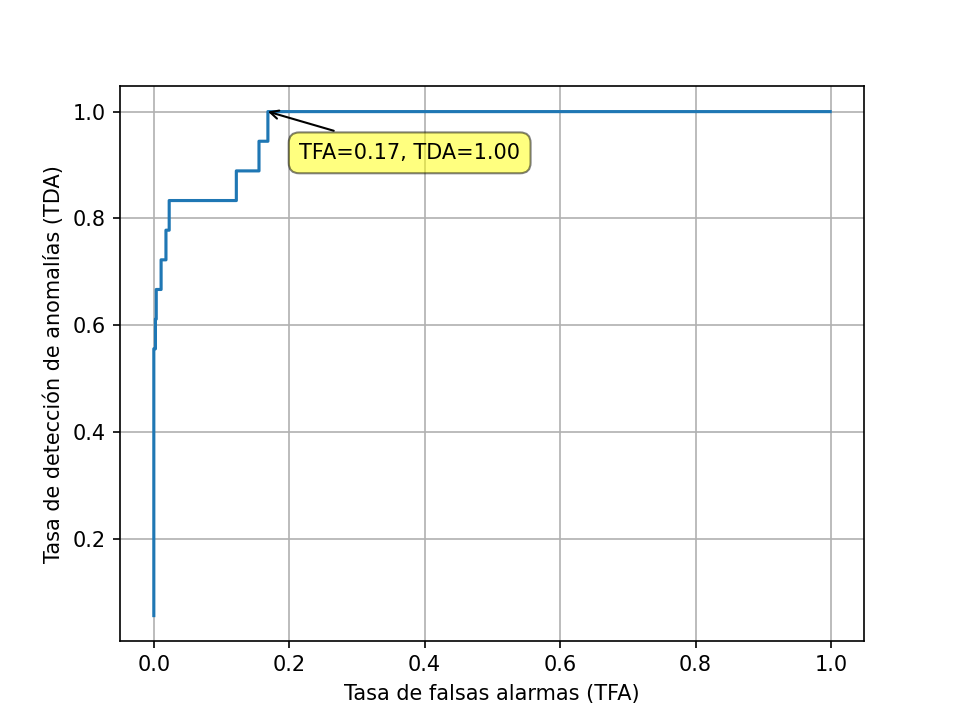

In [4]:
%matplotlib notebook
import mplcursors

fig, af = plt.subplots()
af.plot(tfa, tda)  
plt.xlabel('Tasa de falsas alarmas (TFA)')
plt.ylabel('Tasa de detección de anomalías (TDA)')
plt.grid(True)
# Habilitar la selección de puntos
cursor = mplcursors.cursor(af, hover=True)
cursor.connect("add", lambda sel: sel.annotation.set_text(f'TFA={sel.target[0]:.2f}, TDA={sel.target[1]:.2f}'))
cursor.connect("add", lambda sel: sel.annotation.draggable(True))

plt.show()

### Cálculo del umbral, y resultados del entrenamiento (data_train)

In [5]:
from sklearn.metrics import classification_report

valor_tfa = input("Valor de TFA: ")
valor_tda = input("Valor de TDA: ")
valor_tfa=float(valor_tfa)
valor_tda=float(valor_tda)

def encontrar_indice_mas_cercano(tfa, tda, valor_tfa, valor_tda):
    distancias = []
    for i in range(len(tfa)):
        distancia = np.sqrt((tfa[i] - valor_tfa)**2 + (tda[i] - valor_tda)**2)
        distancias.append(distancia)
    indice_minimo = np.argmin(distancias)
    return indice_minimo

index_umb=encontrar_indice_mas_cercano(tfa, tda, valor_tfa, valor_tda)
umbral_dec=umbral[index_umb]
print ("Umbral para la decisión:", umbral_dec)
print("-----------------------------------------------------------------------")


anomalias = data_train[distances > umbral_dec]
print("Número de anomalías detectadas:", len(anomalias))
print("------------------------------------------------------------------------")

etiq_pred = np.where(distances > umbral_dec, 1, 0)
print(classification_report(etiq_verd_train, etiq_pred))
print("------------------------------------------------------------------------")

cm = confusion_matrix(etiq_verd_train, etiq_pred)
print(cm)
VP = cm[1, 1]
FP = cm[0, 1]
VN = cm[0, 0]
FN = cm[1, 0]
print("VP:",VP)
print("FP:",FP)
print("VN:",VN)
print("FN:",FN)
print("------------------------------------------------------------------------")

TDA= VP/(VP+FN)
TFA=FP/(VN+FP)
Precision=VP/(VP+FP)
especificidad=VN/(VN+FP)
F1 = 2 * (Precision * TDA) / (Precision + TDA)

print("TDA:", TDA)
print("TFA:", TFA)
print("Precision:", Precision)
print("Especificidad",especificidad)
print("F1:", F1)

Valor de TFA: 0.17
Valor de TDA: 1
Umbral para la decisión: 1.8833514446169635
-----------------------------------------------------------------------
Número de anomalías detectadas: 160
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.83      0.91       837
           1       0.11      1.00      0.20        18

    accuracy                           0.83       855
   macro avg       0.56      0.92      0.55       855
weighted avg       0.98      0.83      0.89       855

------------------------------------------------------------------------
[[695 142]
 [  0  18]]
VP: 18
FP: 142
VN: 695
FN: 0
------------------------------------------------------------------------
TDA: 1.0
TFA: 0.16965352449223417
Precision: 0.1125
Especificidad 0.8303464755077659
F1: 0.20224719101123595


### Análisis y resultados en la validación (data_test)

In [7]:
# Detección de anomalías en los datos de validación
VI = np.linalg.inv(np.cov(data_train.T))
distances_v = np.array([min([mahalanobis(test, centroid, VI) for centroid in centroids]) for test in data_test])

anomalias = data_test[distances_v > umbral_dec]
print("Número de anomalías detectadas:", len(anomalias))
print("------------------------------------------------------------------------")

etiq_pred = np.where(distances_v > umbral_dec, 1, 0)
print(classification_report(etiq_verd_test, etiq_pred))
print("------------------------------------------------------------------------")

cm = confusion_matrix(etiq_verd_test, etiq_pred)
print(cm)
VP = cm[1, 1]
FP = cm[0, 1]
VN = cm[0, 0]
FN = cm[1, 0]
print("VP:",VP)
print("FP:",FP)
print("VN:",VN)
print("FN:",FN)
print("------------------------------------------------------------------------")

TDA= VP/(VP+FN)
TFA=FP/(VN+FP)
Precision=VP/(VP+FP)
especificidad=VN/(VN+FP)
F1 = 2 * (Precision * TDA) / (Precision + TDA)

print("TDA:", TDA)
print("TFA:", TFA)
print("Precision:", Precision)
print("Especificidad",especificidad)
print("F1:", F1)

Número de anomalías detectadas: 39
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.86      0.92       204
           1       0.26      1.00      0.41        10

    accuracy                           0.86       214
   macro avg       0.63      0.93      0.67       214
weighted avg       0.97      0.86      0.90       214

------------------------------------------------------------------------
[[175  29]
 [  0  10]]
VP: 10
FP: 29
VN: 175
FN: 0
------------------------------------------------------------------------
TDA: 1.0
TFA: 0.14215686274509803
Precision: 0.2564102564102564
Especificidad 0.8578431372549019
F1: 0.4081632653061224


#### Mostrar cada gráfico por separado

<IPython.core.display.Javascript object>


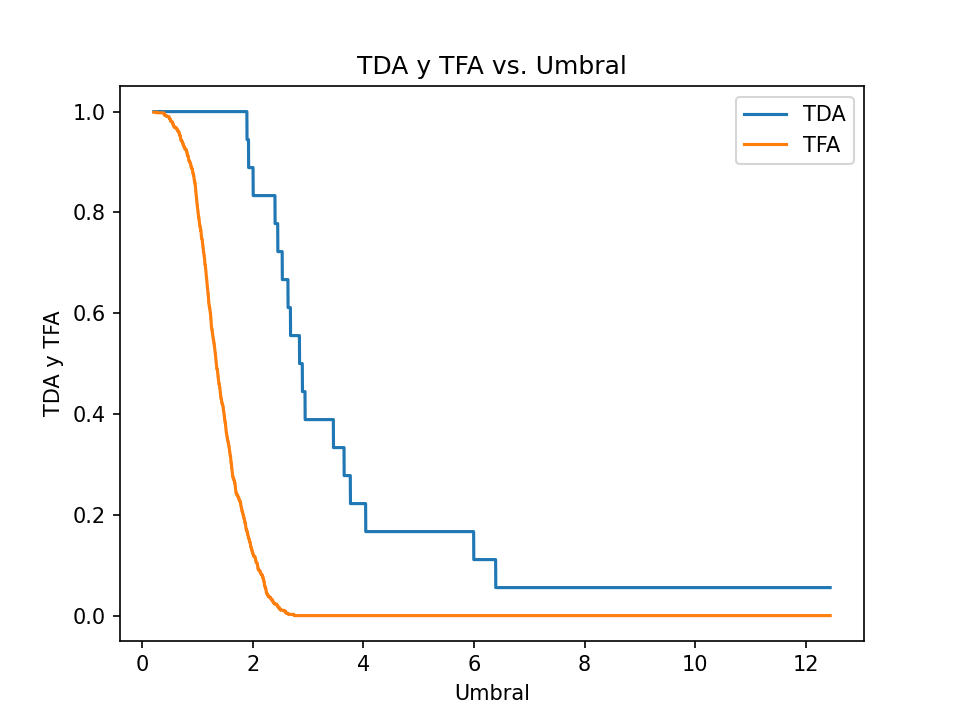

<IPython.core.display.Javascript object>


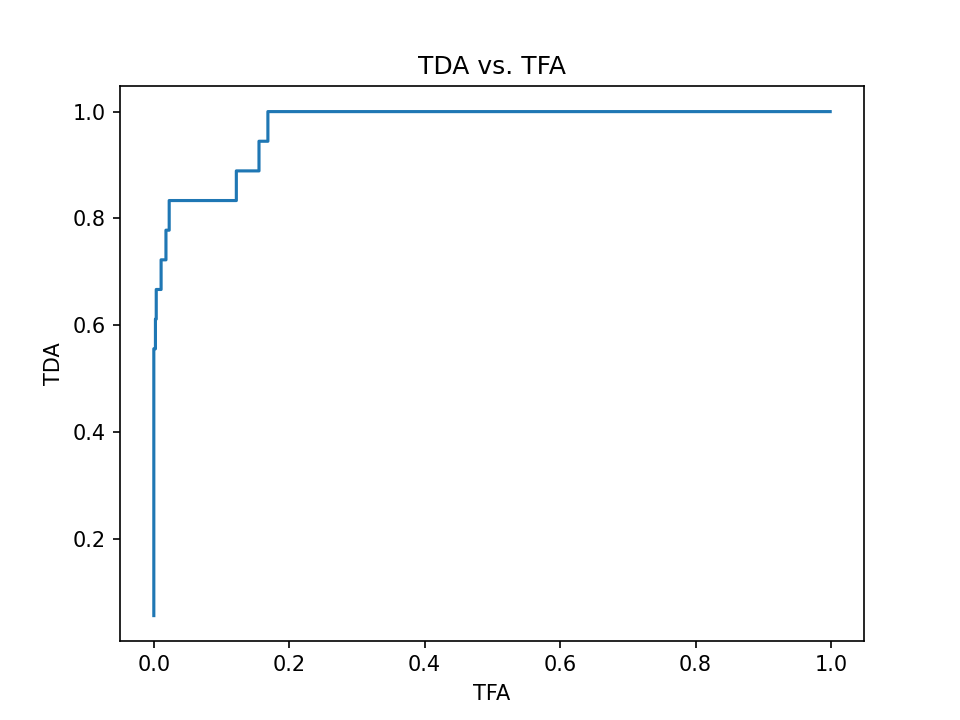

<IPython.core.display.Javascript object>


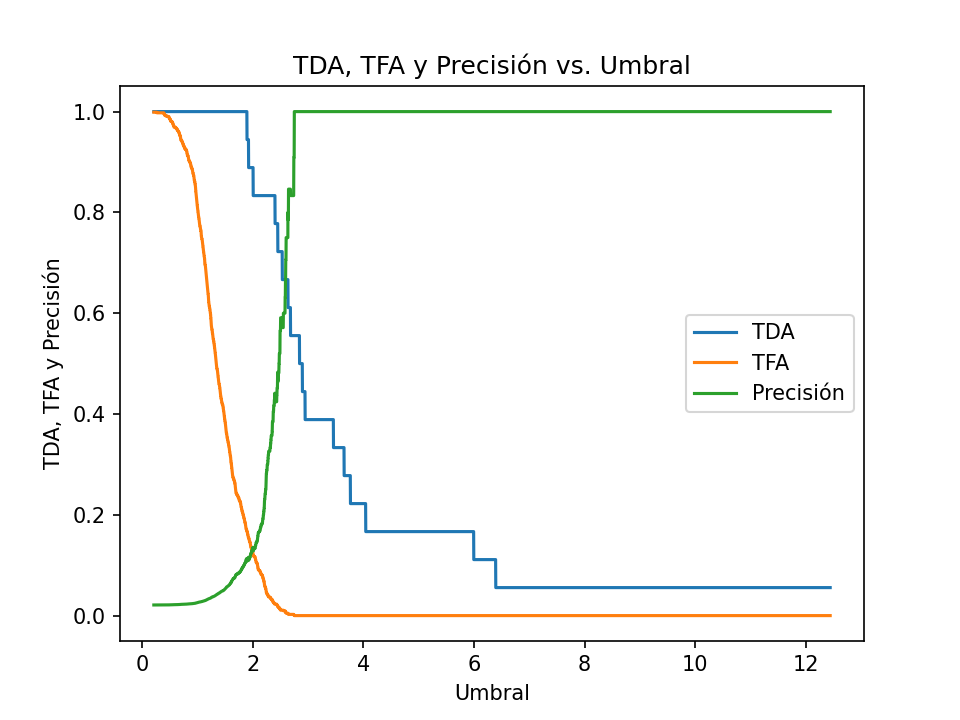

<IPython.core.display.Javascript object>


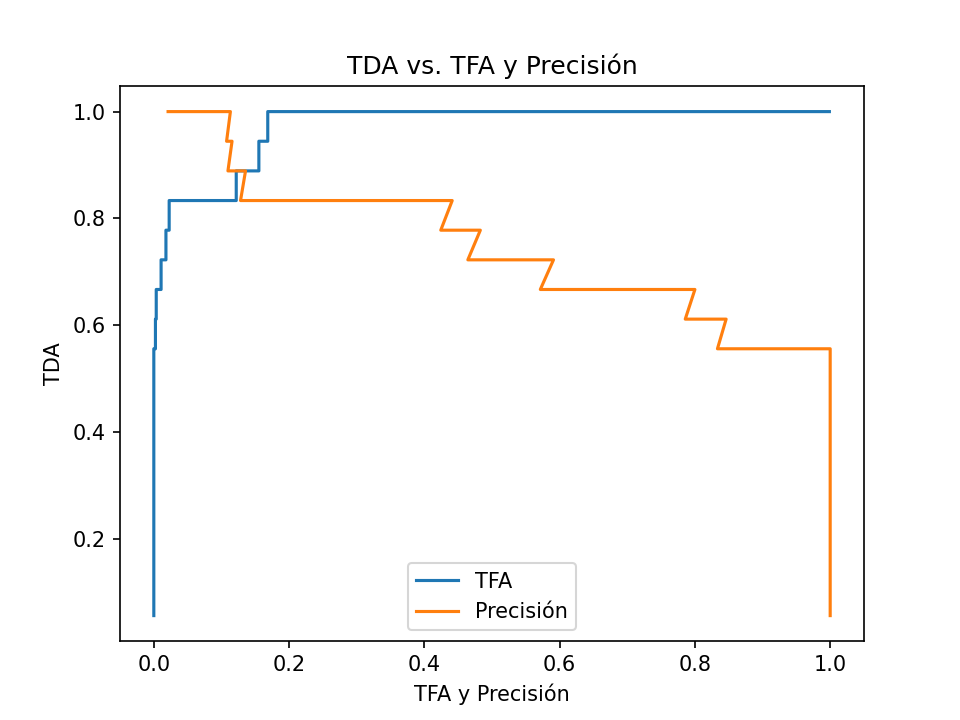

In [8]:
import matplotlib.pyplot as plt

#'axes' es el array de subplots originales
figures = []

# Graficar los gráficos originales por separado
for i, ax in enumerate(axes.flatten(), start=1):
    fig, new_ax = plt.subplots()
    for line in ax.get_lines():
        new_ax.plot(line.get_xdata(), line.get_ydata(), label=line.get_label())
    new_ax.set_title(ax.get_title())
    new_ax.set_xlabel(ax.get_xlabel())
    new_ax.set_ylabel(ax.get_ylabel())
    if i == 1 or i == 3 or i == 4:
        new_ax.legend()
    figures.append(fig)
    plt.show()

#### Graficar una banda horizontal para ajuste fino del umbral

<IPython.core.display.Javascript object>


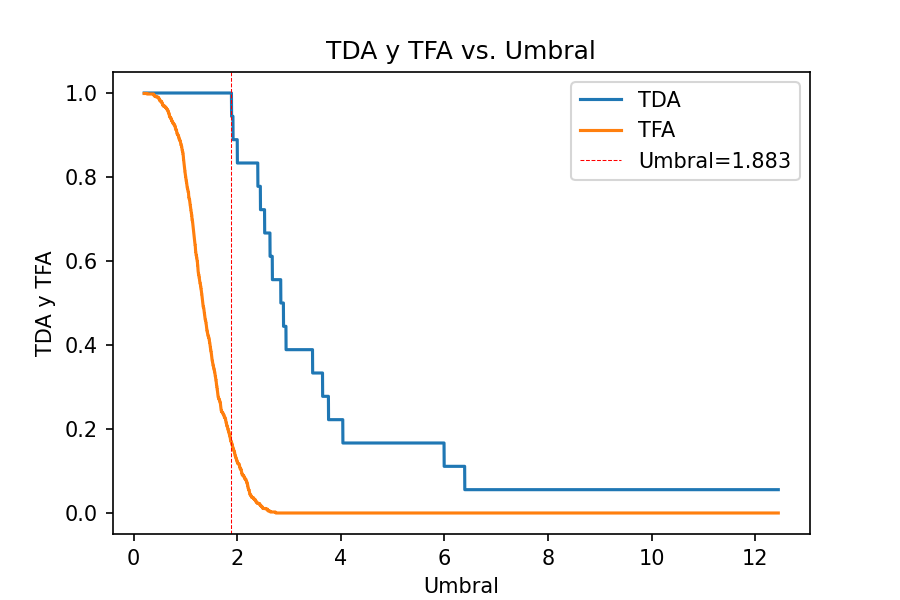

<IPython.core.display.Javascript object>


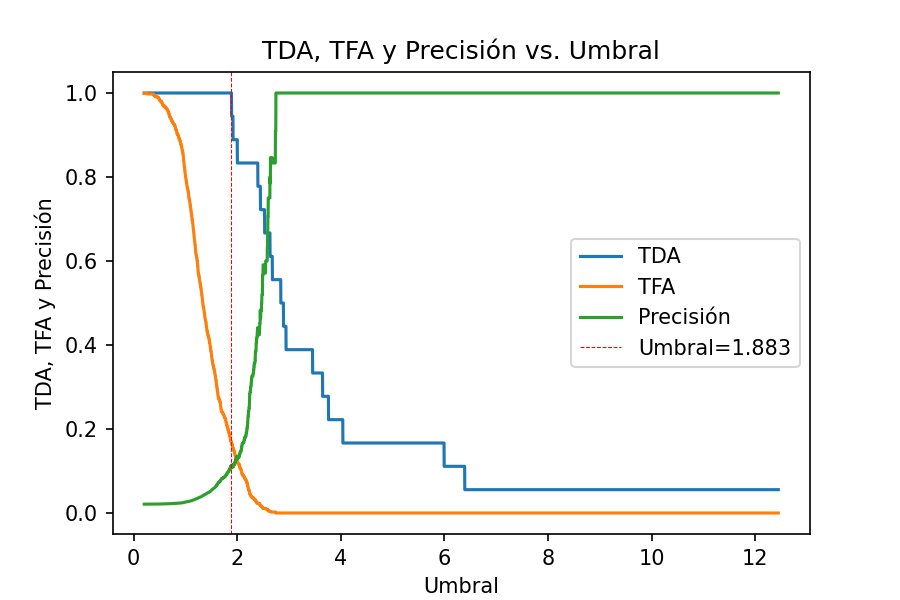

In [9]:
# Crear el gráfico
plt.figure(figsize=(6, 4))
plt.plot(umbral, tda, label='TDA')
plt.plot(umbral, tfa, label='TFA')
plt.xlabel('Umbral')
plt.ylabel('TDA y TFA')
plt.title('TDA y TFA vs. Umbral')
plt.legend()
# Agregar líneas verticales discontinuas
plt.axvline(x=umbral_dec, color='r', linestyle='--', linewidth=0.5, label=f'Umbral={umbral_dec:.3f}')
plt.legend()
plt.show()

# Crear el gráfico
plt.figure(figsize=(6, 4))
plt.plot(umbral, tda, label='TDA')
plt.plot(umbral, tfa, label='TFA')
plt.plot(umbral,precis,label='Precisión')
plt.xlabel('Umbral')  
plt.ylabel('TDA, TFA y Precisión') 
plt.title('TDA, TFA y Precisión vs. Umbral')
plt.legend()
# Agregar líneas verticales discontinuas
plt.axvline(x=umbral_dec, color='r', linestyle='--', linewidth=0.5, label=f'Umbral={umbral_dec:.3f}')
plt.legend()
plt.show()

### Ajuste fino del umbral 
#### Valor definitivo de Umbral=1.89

In [10]:
umbral_fino = input("Valor del umbral:")
umbral_fino=float(umbral_fino)

print(" \n  \n ---------------- Datos de entrenamiento ----------------------------- \n ")
anomalias = data_train[distances > umbral_fino]
print("Número de anomalías detectadas:", len(anomalias))


etiq_pred = np.where(distances > umbral_fino, 1, 0)
print("------------------------------------------------------------------------")

cm = confusion_matrix(etiq_verd_train, etiq_pred)
print(cm)
VP = cm[1, 1]
FP = cm[0, 1]
VN = cm[0, 0]
FN = cm[1, 0]
print("VP:",VP)
print("FP:",FP)
print("VN:",VN)
print("FN:",FN)
print("------------------------------------------------------------------------")

TDA= VP/(VP+FN)
TFA=FP/(VN+FP)
Precision=VP/(VP+FP)
especificidad=VN/(VN+FP)
F1 = 2 * (Precision * TDA) / (Precision + TDA)

print("TDA:", TDA)
print("TFA:", TFA)
print("Precision:", Precision)
print("Especificidad",especificidad)
print("F1:", F1)

print(" \n  \n ---------------- Datos de validación --------------------------- \n ")
anomalias = data_test[distances_v > umbral_fino]
print("Número de anomalías detectadas:", len(anomalias))


etiq_pred = np.where(distances_v > umbral_fino, 1, 0)
print("------------------------------------------------------------------------")

cm = confusion_matrix(etiq_verd_test, etiq_pred)
print(cm)
VP = cm[1, 1]
FP = cm[0, 1]
VN = cm[0, 0]
FN = cm[1, 0]
print("VP:",VP)
print("FP:",FP)
print("VN:",VN)
print("FN:",FN)
print("------------------------------------------------------------------------")

TDA= VP/(VP+FN)
TFA=FP/(VN+FP)
Precision=VP/(VP+FP)
especificidad=VN/(VN+FP)
F1 = 2 * (Precision * TDA) / (Precision + TDA)

print("TDA:", TDA)
print("TFA:", TFA)
print("Precision:", Precision)
print("Especificidad",especificidad)
print("F1:", F1)

Valor del umbral:1.89
 
  
 ---------------- Datos de entrenamiento ----------------------------- 
 
Número de anomalías detectadas: 159
------------------------------------------------------------------------
[[696 141]
 [  0  18]]
VP: 18
FP: 141
VN: 696
FN: 0
------------------------------------------------------------------------
TDA: 1.0
TFA: 0.16845878136200718
Precision: 0.11320754716981132
Especificidad 0.8315412186379928
F1: 0.2033898305084746
 
  
 ---------------- Datos de validación --------------------------- 
 
Número de anomalías detectadas: 39
------------------------------------------------------------------------
[[175  29]
 [  0  10]]
VP: 10
FP: 29
VN: 175
FN: 0
------------------------------------------------------------------------
TDA: 1.0
TFA: 0.14215686274509803
Precision: 0.2564102564102564
Especificidad 0.8578431372549019
F1: 0.4081632653061224


### Análisis de la calidad del agrupamiento realizado
#### Índices de silueta para cada valor de k

In [31]:
from sklearn.metrics import silhouette_score

def calcular_indice_silueta(X, min_k=2, max_k=15):
    siluetas = []
    for k in range(min_k, max_k + 1):
        centroids, labels, _ = kmeans_mahalanobis(X, k)
        score = silhouette_score(X, labels, metric='mahalanobis', VI=np.linalg.inv(np.cov(X.T)))
        siluetas.append(score)
        print(f'Número de clústeres: {k}, Índice de Silueta: {score:.4f}')
    return siluetas

# Llamar a la función con los datos de entrenamiento
siluetas=calcular_indice_silueta(data_train)


Número de clústeres: 2, Índice de Silueta: 0.1616
Número de clústeres: 3, Índice de Silueta: 0.1614
Número de clústeres: 4, Índice de Silueta: 0.1666
Número de clústeres: 5, Índice de Silueta: 0.1566
Número de clústeres: 6, Índice de Silueta: 0.1813
Número de clústeres: 7, Índice de Silueta: 0.1827
Número de clústeres: 8, Índice de Silueta: 0.1895
Número de clústeres: 9, Índice de Silueta: 0.1914
Número de clústeres: 10, Índice de Silueta: 0.2033
Número de clústeres: 11, Índice de Silueta: 0.2078
Número de clústeres: 12, Índice de Silueta: 0.2042
Número de clústeres: 13, Índice de Silueta: 0.2101
Número de clústeres: 14, Índice de Silueta: 0.2078
Número de clústeres: 15, Índice de Silueta: 0.2087


<IPython.core.display.Javascript object>


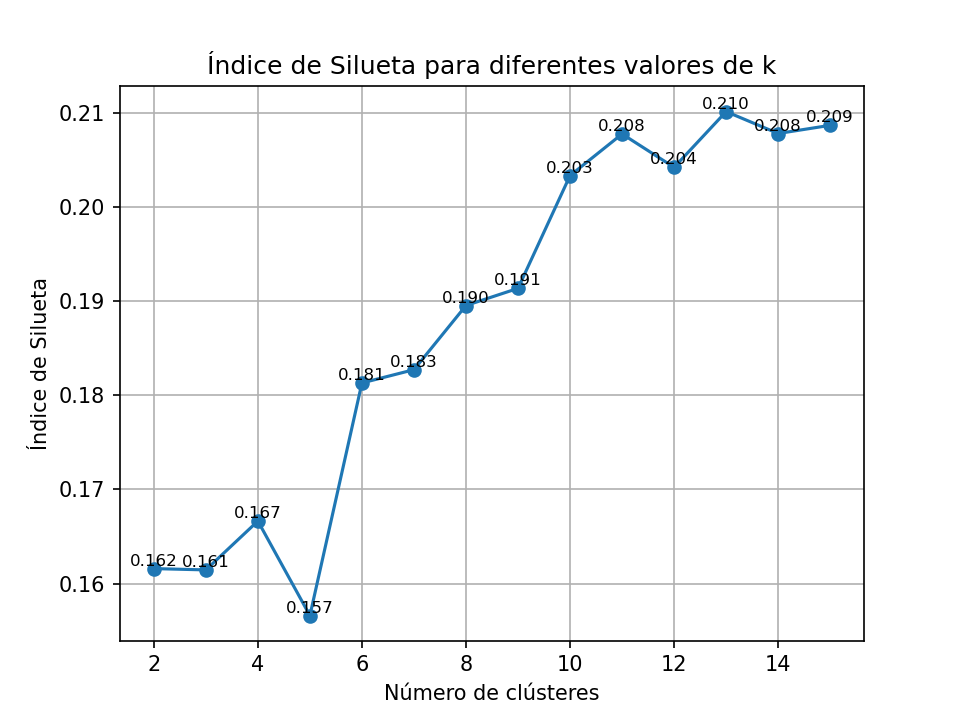

In [39]:
plt.plot(range(2, 16), siluetas, marker='o', linestyle='-')
for i, score in enumerate(siluetas, start=2):
    plt.text(i, score, f'{score:.3f}', ha='center', va='bottom', fontsize=8)
plt.xlabel('Número de clústeres')
plt.ylabel('Índice de Silueta')
plt.title('Índice de Silueta para diferentes valores de k')
plt.grid(True)
plt.show()

### Análisis de TFA cuando TDA=1, para diferentes valores de k
#### Mínimo valor de TFA/TDA=1, para diferentes valores de k

In [44]:
min_tfa_values = []

for k in range(2, 16):
    centroids, labels, distances = kmeans_mahalanobis(data_train, k, max_iters=80)
    
    umbral = np.arange(np.min(distances), np.max(distances), 0.001)
    tda = []
    tfa = []
    
    for i in range(len(umbral)):
        predicciones = np.where(distances > umbral[i], 1, 0)
        cm = confusion_matrix(etiq_verd_train, predicciones) 
        VP = cm[1, 1]
        FP = cm[0, 1]
        VN = cm[0, 0]
        FN = cm[1, 0]
        TDA = VP / (VP + FN)
        TFA = FP / (VN + FP)
        tda.append(TDA)
        tfa.append(TFA)
    
    # Encontrar el menor valor de TFA cuando TDA es igual a 1
    min_tfa = min([tfa[j] for j in range(len(tda)) if tda[j] == 1], default=np.nan)
    min_tfa_values.append(min_tfa)
    print(f'Número de clústeres: {k}, TFA/TDA=1: {min_tfa:.4f}')

Número de clústeres: 2, TFA/TDA=1: 0.2019
Número de clústeres: 3, TFA/TDA=1: 0.1541
Número de clústeres: 4, TFA/TDA=1: 0.3978
Número de clústeres: 5, TFA/TDA=1: 0.6237
Número de clústeres: 6, TFA/TDA=1: 0.4588
Número de clústeres: 7, TFA/TDA=1: 0.1685
Número de clústeres: 8, TFA/TDA=1: 0.8435
Número de clústeres: 9, TFA/TDA=1: 0.7802
Número de clústeres: 10, TFA/TDA=1: 0.6344
Número de clústeres: 11, TFA/TDA=1: 0.7300
Número de clústeres: 12, TFA/TDA=1: 0.6547
Número de clústeres: 13, TFA/TDA=1: 0.6977
Número de clústeres: 14, TFA/TDA=1: 0.5149
Número de clústeres: 15, TFA/TDA=1: 0.6476


<IPython.core.display.Javascript object>


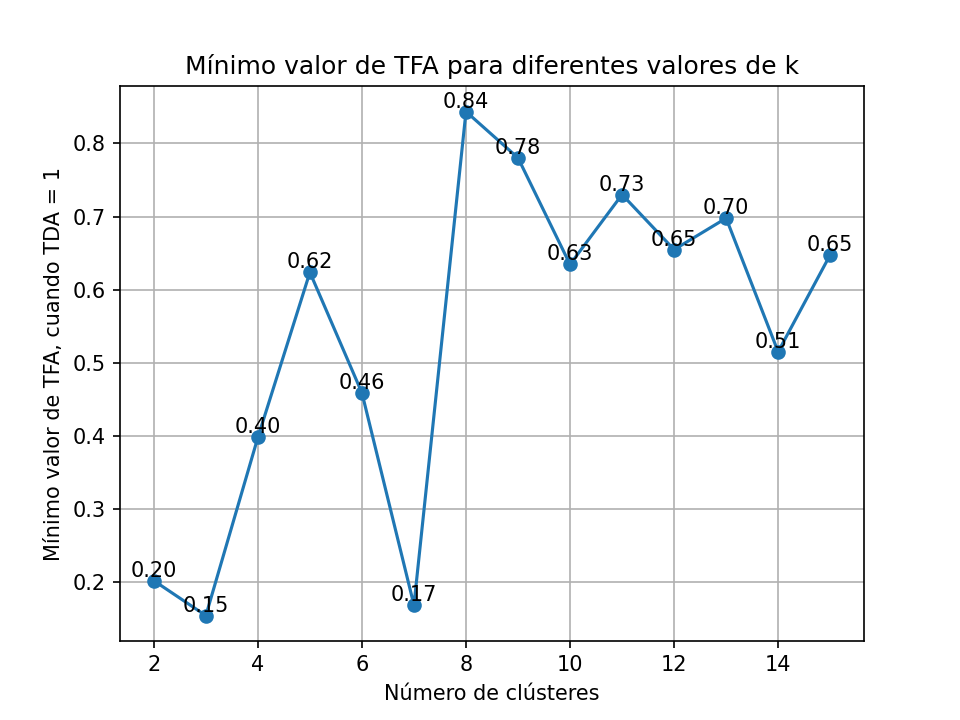

In [45]:
# Graficar los valores de TFA mínimos/TDA=1 para cada valor de k
plt.plot(range(2, 16), min_tfa_values, marker='o', linestyle='-')
for i, value in enumerate(min_tfa_values, start=2):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')
plt.xlabel('Número de clústeres')
plt.ylabel('Mínimo valor de TFA, cuando TDA = 1')
plt.title('Mínimo valor de TFA para diferentes valores de k')
plt.grid(True)
plt.show()